In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import numpy as np
import time
from util_hmm_pytorch import *
from util_data import *
from util_plots import *

In [2]:
## dataset parameters
T = 200 ## sequence length
num_series = 30
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
training_epochs = 50 
D = 2
## Model parameters
K =  4## number of hidden states

In [3]:
Disps = np.load('/home/hao/Research/amortized/data/Disps.bin.npy')
As_true = np.load('/home/hao/Research/amortized/data/As_true.bin.npy')
As_pred = np.zeros((num_series, K, K))
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))

In [4]:
## generate time series
x0, y0, init_v, init_v_rand_dir = intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [5]:
Disps.shape

(30, 200, 2)

In [6]:
## training with one time series at a time, i.e. there are num_series models
for s in range(num_series):
    Y = torch.from_numpy(Disps[s]).float()
    alpha_init_0, alpha_trans_0, m_0, beta_0, nu_0, W_0, alpha_init_hat, alpha_trans_hat, m_ks, beta_ks, nu_ks, W_ks = pirors(Y, T, D, K)
    epoch_elbos = []
    for i in range(training_epochs):
        ## VBE step
        log_gammas, log_eta = vbE_step(alpha_init_hat, alpha_trans_hat, nu_ks, W_ks, m_ks, beta_ks, Y, T, D, K)
        N_ks, Y_ks, S_ks = stats(log_gammas, Y, D, K)
        ## VBM step
        alpha_init_hat, alpha_trans_hat, nu_ks, W_ks, m_ks, beta_ks, cov_ks = vbM_step(log_eta, alpha_init_0, alpha_trans_0, nu_0, W_0, m_0, beta_0, N_ks, Y_ks, S_ks, T, D, K)
    #     epoch_elbo = elbo(log_gammas, log_eta, alpha_init_0, alpha_trans_0, nu_0, W_0, m_0, beta_0, N_ks, Y_ks, S_ks, alpha_init_hat, alpha_trans_hat, nu_ks, W_ks, m_ks, beta_ks, Y, N, D, K)
    #     epoch_elbos.append(epoch_elbo)
    #     print('Iteration:%d, ELBO:%f' % ((i+1), epoch_elbo))
    final_covs[s] = cov_ks ## mean of inverse wishart
    final_mus[s] = m_ks.data.numpy() ## mean of gaussian
    As_pred[s] = alpha_trans_hat.data.numpy()
    print('training completed : %d' % (s))

training completed : 0
training completed : 1
training completed : 2
training completed : 3
training completed : 4
training completed : 5
training completed : 6
training completed : 7
training completed : 8
training completed : 9
training completed : 10
training completed : 11
training completed : 12
training completed : 13
training completed : 14
training completed : 15
training completed : 16
training completed : 17
training completed : 18
training completed : 19
training completed : 20
training completed : 21
training completed : 22
training completed : 23
training completed : 24
training completed : 25
training completed : 26
training completed : 27
training completed : 28
training completed : 29


In [8]:
fs = 3.0 ## figure size
vmax = 0.3 ## cmap maximum value, to make off-diagonal elements more visible
width_space = 0.05 # space between figures
height_space = 0.05 # space between figures
cov_flag = False # plot the covariances or not
legend_flag = False # plot the legend bar or not
save_flag = True ## save or not

In [8]:
## plot method 1
# plot_circle_transition(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)

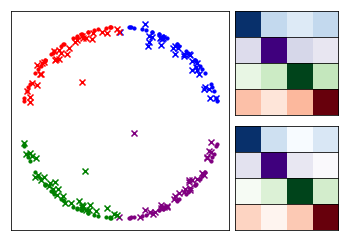

In [9]:
## plot method 2
plot_circle_transition_colorcode(num_series, init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)

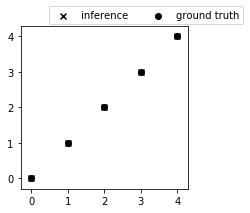

In [13]:
a = np.arange(5)
fig2 = plt.figure(figsize=(3,3))
ax1 = fig2.add_subplot(111)
ax1.scatter(a, a, color='k', marker='x', label='inference')
ax1.scatter(a, a, color='k', marker='o', label='ground truth')
ax1.legend(loc='upper center', bbox_to_anchor=(0.75, 1.15), ncol=2)
fig2.savefig('legend_v1.svg', bbox_inches='tight')